In [21]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
sys.path.append('C:/Users/AMO lab/Documents/Codes/Rydberg')

# Tof_CCMOT_op_0.06_0.10_40ms_1.00V
# filepath = 'E:/Sync2/Data/2023/5/25/'、

filepath = 'D:\\OneDrive - 南方科技大学\\各种书面文件（培养方案里的）\\master thesis\\figures\\MOT temperature measurement\\代码改过之后的最终版本\\啥也没做，一号，300us的pulse\\'
# filepath = 'C:\\Users\AMO lab\Documents\Rydberg Data\\2023\\8\\9_3\\Tof_CCMOT_op2_0.06_0.10_40ms_1.00V\\'

bg = plt.imread(filepath+'ToF_bg.png')
height,width = bg.shape
# width = 416
# height = 400
num = 16  ##################################################拟合的点的数量##########################################################
image_stack = np.zeros((height, width, num))

for i in range(num):
    # 构建文件名
    filename = filepath + "data_ToF_" + str(i) + ".png"
    
    # 从文件加载灰度图像
    image = plt.imread(filename)
    
    # 确保图像为灰度图像
    if image.ndim > 2:
        image = image[:, :, 0]
    
    # 将图像存储到矩阵中的对应位置
    image_stack[:, :, i] = image.astype(np.float32) +  bg.astype(np.float32)

# 打印矩阵形状
print("矩阵形状:", image_stack.shape)
data_all = image_stack



矩阵形状: (330, 512, 16)


In [22]:
image_stack_new = image_stack[70:280,170:350,:] 
image = image_stack_new[:,:,0]
data_all =image_stack_new
print(data_all.shape)

(210, 180, 16)


[-9.08754086e-03  1.32135814e+02 -1.03354884e+01  7.84919007e-02]


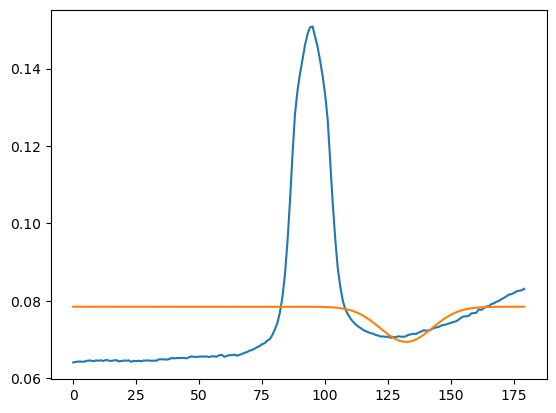

In [23]:
def gaussian(x, amplitude, xo, sigma, bias = 0):
    xo = float(xo)
    g = amplitude * np.exp(-( (x - xo)**2 / (2* sigma**2) )) + bias
    return g

## Attemp for fitting  
ny,nx,n = data_all.shape
x = np.arange(0, nx)
y = np.arange(0, ny)
image = data_all[:,:,1]
# plt.imshow(image)
# plt.plot(image.mean(axis = 1))
plt.plot(x,image.mean(axis = 0))
popt1, pcov1 = curve_fit(gaussian, x, image.mean(axis = 0),p0 = (0.05, 125, 10, 0.0))
print(popt1)
plt.plot(x, gaussian(x,popt1[0],popt1[1],popt1[2],popt1[3]))

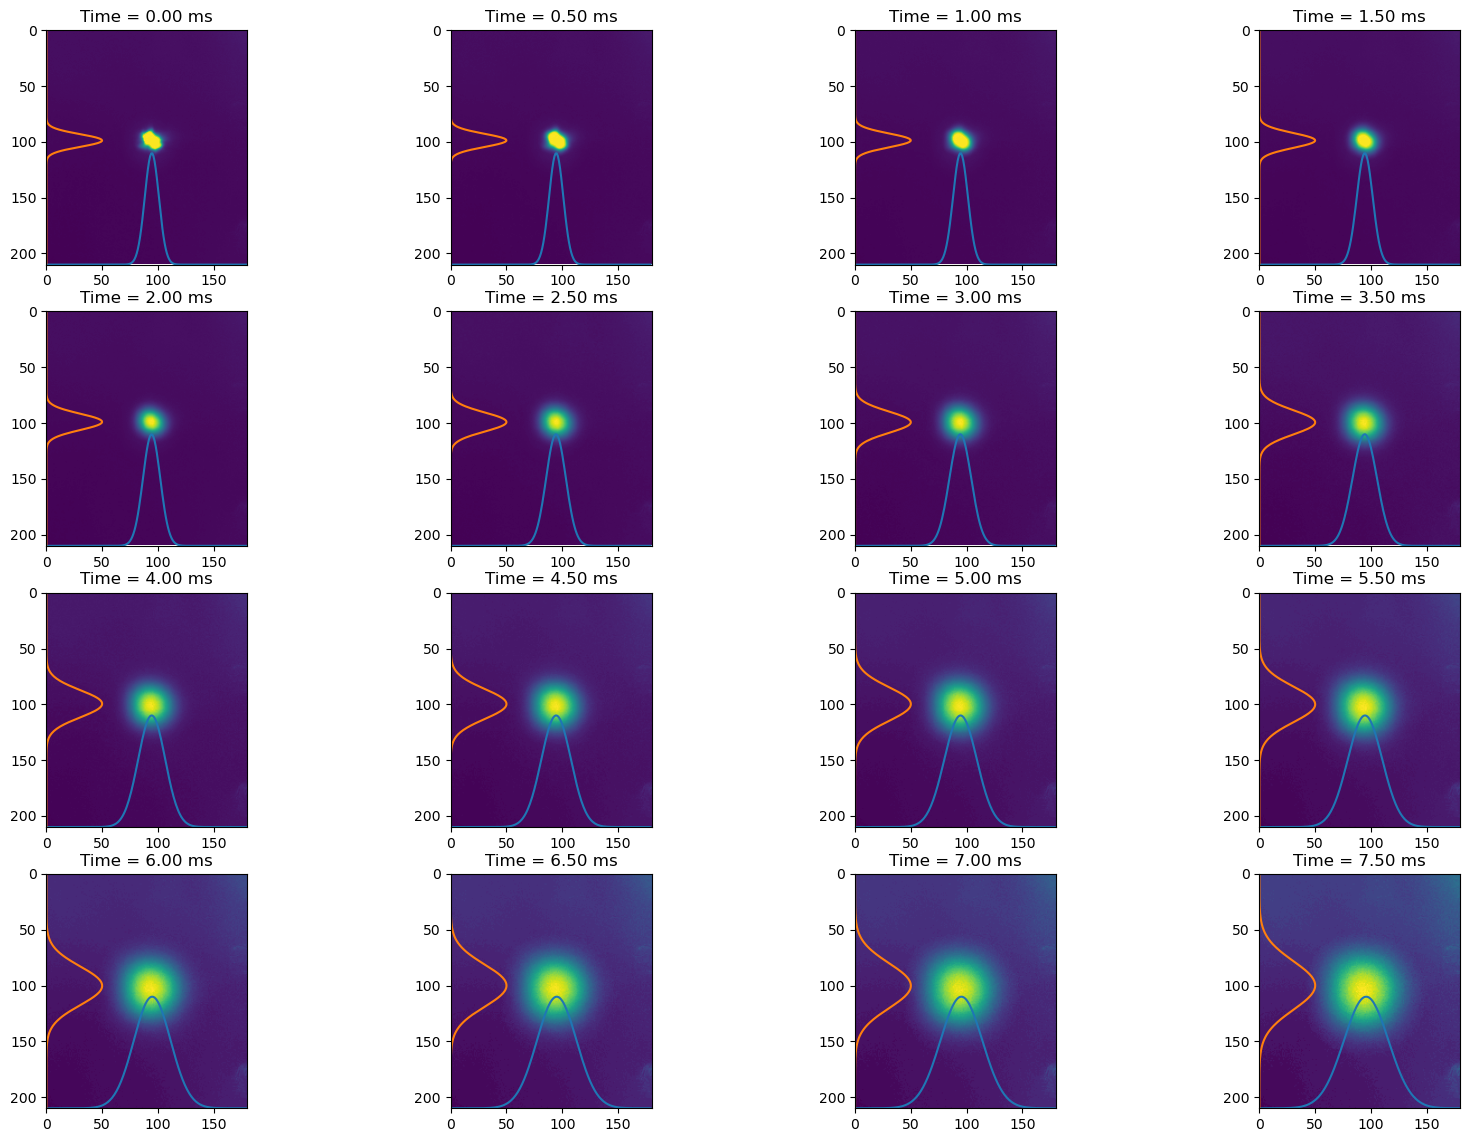

In [24]:
start_t = np.arange(0,num,1)*0.5e-3
duration = 300e-6 # measure time 
delay = 0e-6 # measure after start_t

X, Y = np.meshgrid(x, y)
# 初始拟合参数
fit_res = np.zeros((n,5))

plt.figure(1,figsize = [20,14])


for i in range(len(start_t)):
# 读取灰度值二维数组
    image = data_all[:,:,i] 
    
    initial_guess1 = (np.max(image.mean(axis = 0)), np.argmax(image.mean(axis = 0)), 2, -0.002)
    initial_guess2 = (np.max(image.mean(axis = 1)), np.argmax(image.mean(axis = 1)), 2, -0.002)
    
    # 执行拟合
    popt1, pcov1 = curve_fit(gaussian, x, image.mean(axis = 0), p0=initial_guess1,)
    popt2, pcov2 = curve_fit(gaussian, y, image.mean(axis = 1), p0=initial_guess2)
    
    
    # 提取拟合结果
    amplitude, xo,  sigma_x, bias_x = popt1
    amplitude, yo,  sigma_y, bias_y = popt2
    fit_res[i,1] = xo
    fit_res[i,2] = yo
    fit_res[i,3] = sigma_x
    fit_res[i,4] = sigma_y
    fit_res[i,0] = amplitude
    # print('xo = ', xo, ',yo = ', yo)
    # print('sigma_x = ', sigma_x, 'sigma_y = ', sigma_y)


    plt.subplot(4,4,i+1)
    plt.imshow(image)
    plt.plot(x, data_all.shape[0]-gaussian(x,1,xo,sigma_x)*100)
    plt.plot(gaussian(y,1,yo,sigma_y)*50,y)
    plt.xlim([0,data_all.shape[1]])
    plt.ylim([data_all.shape[0],0])
#     plt.xlabel('x')
#     plt.ylabel('y') 
    time = start_t[i]*1e3+ delay*1e3
    plt.title('Time = '+'%.2f'%time +' ms')
    plt.savefig(filepath + 'spot_fitting.png')

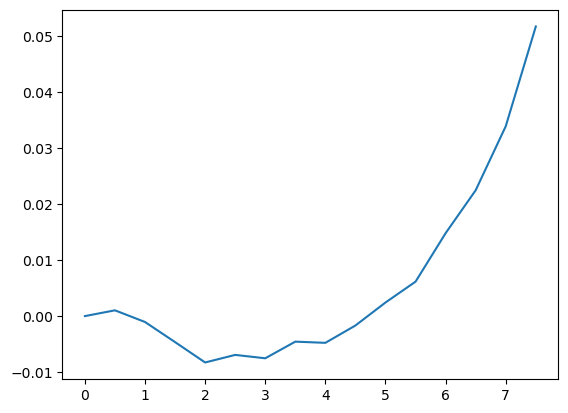

In [25]:
plt.plot((start_t+delay) *1e3,(fit_res[:,1]-fit_res[0,1]) * scale)

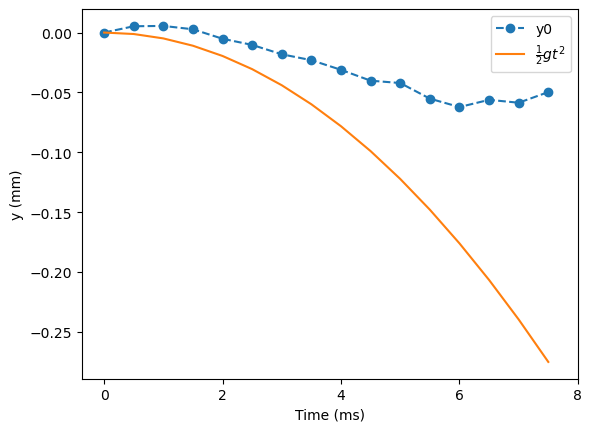

In [26]:
def fall(t,bias,t0 = 0,v0 = 0):
    return v0*(t-t0)-0.5*9.78*(t-t0)**2  + bias

scale = 1/23

# plt.plot((start_t+delay) *1e3,-(fit_res[:,2]-fit_res[0,2])*36.87*1e-3,'o--',label = 'y0')
plt.plot((start_t+delay) *1e3,-(fit_res[:,2]-fit_res[0,2])*scale,'o--',label = 'y0')

plt.plot((start_t+delay )*1e3,fall(start_t+delay,0,0)*1e3 ,label = r'$\frac{1}{2}gt^2$')
# plt.plot((start_t+delay)*1e3,-(fit_res[:,2] - fit_res[0,2])* 10*5.86e-3 ,'o--',label = 'y0 * magnefication + bias')
# plt.plot((start_t+delay)*1e3,-0.5*9.8*(start_t+delay)**2 * 1e3,'--',label = r'$\frac{1}{2}gt^2$')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('y (mm)')
plt.xticks([0,2,4,6,8])
plt.savefig(filepath + 'falling.png')

sigma_x_0 = 0.259 mm, beam size = 1.034 mm, temperature = 119.018uK, t0 =-0.221 ms
sigma_y_0 = 0.249 mm, beam size = 0.998 mm, temperature = 165.422uK, t0 =0.324 ms


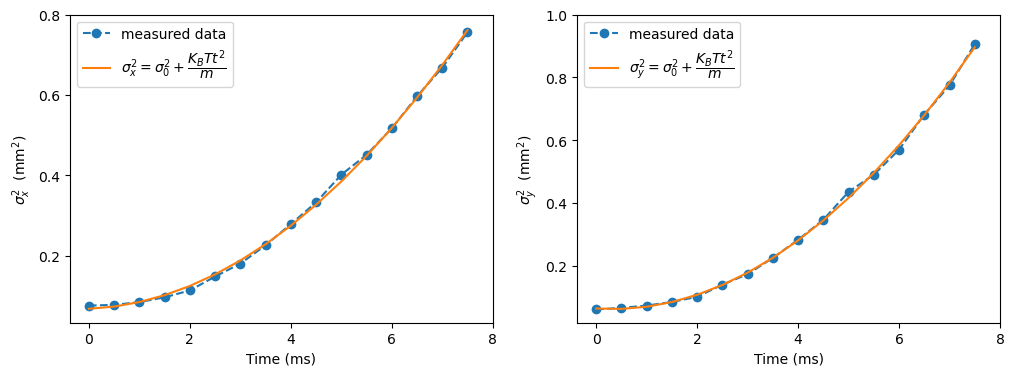

In [32]:
## Fitting for the temperature
# Boltzmann’s constant
k_B = 1.3806504e-23
# Atomic mass of Rb85
m = 1.409993199e-25
# Gravitational aceleration
g = 9.7803
# Gaussian radius of cold atom colud
# sigma_0 = 1.33168672*5.86e-6

# sigma_t = (fit_res[:,3] * 36.87e-6)**2
# sigma_y_t = (fit_res[:,4] * 36.87e-6)**2

sigma_t = (fit_res[:,3] * scale*1e-3)**2
sigma_y_t = (fit_res[:,4] * scale*1e-3)**2
def expansion( t,sigma_0, T,t0):
    return sigma_0**2+k_B*T*(t-t0)**2/m

initial_guess = [1e-4,20e-6,0]
popt, pcov = curve_fit(expansion,start_t +delay, sigma_t, p0=initial_guess)# ,bounds = ([0,0,0],[np.inf,np.inf,10e-3]))
str_1 = 'sigma_x_0 = '+'%.3f'%(popt[0]*1e3)+' mm, beam size = '+'%.3f'%(popt[0]*1e3*4)+' mm, temperature = '+'%.3f'%(popt[1]*1e6) +'uK, t0 ='+'%.3f'%(popt[2]*1e3)+' ms'
print(str_1)

popt_y, pcov = curve_fit(expansion,start_t +delay, sigma_y_t , p0=initial_guess)# ,bounds = ([0,0,0],[np.inf,np.inf,10e-3]))
str_3 = 'sigma_y_0 = '+'%.3f'%(popt_y[0]*1e3) +' mm, beam size = '+'%.3f'%(popt_y[0]*1e3*4) +' mm, temperature = '+'%.3f'%(popt_y[1]*1e6)+'uK, t0 ='+'%.3f'%(popt_y[2]*1e3) +' ms'

print(str_3)


plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(start_t* 1e3+delay* 1e3, sigma_t*1e6,'--o',label = r'measured data')
plt.plot(start_t* 1e3+delay* 1e3,expansion(start_t+delay,popt[0],popt[1],popt[2])*1e6,label = '$\sigma_x^2 = \sigma_0^2 + \dfrac{K_BTt^2}{m}$')
plt.legend()
plt.ylabel(r'$\sigma_x^2$  (mm$^2)$')
plt.xlabel('Time (ms)')
plt.xticks([0,2,4,6,8])
plt.yticks([0.2,0.4,0.6,0.8])

plt.subplot(1,2,2)
plt.plot(start_t* 1e3+delay* 1e3, sigma_y_t*1e6,'--o',label = r'measured data')
plt.plot(start_t* 1e3+delay* 1e3,expansion(start_t+delay,popt_y[0],popt_y[1],popt_y[2])*1e6,label = '$\sigma_y^2 = \sigma_0^2 + \dfrac{K_BTt^2}{m}$')
plt.legend()
plt.ylabel(r'$\sigma_y^2$  (mm$^2)$')
plt.xlabel('Time (ms)')
plt.xticks([0,2,4,6,8])
plt.yticks([0.2,0.4,0.6,0.8,1.0])

plt.savefig(filepath + 'expansion.png')

fh = open(filepath + 'fitting.txt', 'w', encoding='utf-8')
fh.write(str_1)
fh.write('\n')
fh.write(str_3)
fh.close()
# np.savetxt(filepath + 'fitting.txt',str_1, str_2)